https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets
from utility.ML import ML

In [2]:
########### switches ################################

saveName='Oct21-2018_2'
saveFolder = saveName
saveplots=False
createSubmit = True
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"

############# Options/Args #########################

verbose=True
lag_length = 5
diff = True
diffRel = False 
addPriceRange = True

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

#these columns will be dropped in createTrain/Val/Test --> Depracated
col_targets=[]

####### mean Encode (with Reg) #####

meanEncode=True #this is just necessary condition for mean encoding. but need to turn on individual switches below to include columsn of target encoding.
meanEncodeCol=[ #this is for lag features.
             'shop',
             'item',
             'item_cat',
            ]

agg_targ = {'item_cnt_day':'sum'} #target_encoding!
# agg_targ = {'item_cnt_day':'mean'} #target_encoding!

Regularize = True
enc_cnt_per_shop = True
enc_cnt_per_item = True
enc_cnt_per_item_cat = True
enc_priceRange = True

targEnc_to_Reg = {}
NaN_targEnc = {}

if(enc_cnt_per_shop):targEnc_to_Reg.update({'shop_id':'shop'})
if(enc_cnt_per_item):targEnc_to_Reg.update({'item_id':'item'})
if(enc_cnt_per_item_cat):targEnc_to_Reg.update({'item_category_id':'item_cat'})
if(enc_priceRange):targEnc_to_Reg.update({'price_range':'price_range'})

if(enc_cnt_per_shop):NaN_targEnc.update({'shop':-999})
if(enc_cnt_per_item):NaN_targEnc.update({'item':-999})
if(enc_cnt_per_item_cat):NaN_targEnc.update({'item_cat':-999})
if(enc_priceRange):NaN_targEnc.update({'price_range':-999})

####################################

#columns to keep
col_to_keep = [
                'shop_id',
                'item_id',
                #'item_price',
                'item_category_id',
                'item_cnt_day',
                ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

    
opt = {
        'verbose':verbose,
        'lag_length':lag_length,
        'diff':diff,
        'diffRel':diffRel,
        'target':target,
        'col_to_keep':col_to_keep,
        'groupby_list':groupby_list,
        'agg_dict':agg_dict,
        'agg_targ':agg_targ,
        'col_targets':col_targets,
        'meanEncode':meanEncode,
        'meanEncodeCol':meanEncodeCol,
        'targEnc_to_Reg':targEnc_to_Reg,
        'NaN_targEnc':NaN_targEnc,
        } 


#clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################

creating folder: /Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/Oct21-2018_2
WILL CREATE SUBMIT FILE!


In [3]:
#del Sets
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.translateItemCategoryId()
Sets.addItemCategoryId()
Sets.addTranslatedItemCategoryId()
Sets.addYMcolumn()
bin_edges=[0,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()


sales_train shape: (2935849, 6)

lag_length: 5
diff: True
diffRel: False
target: shop_item_cnt_month

target encoding: {'item_cnt_day': 'sum'}


Checking for duplicates in sales_train

Found 6 duplicates in sales_train : [  76962 1435367 1496766 1671873 1866340 2198566]
Kept first, removed duplicates

Checking for duplicates in test
Found no duplicates in test

Format 'date' to 'datetime' in sales_train

Add new column: 'item_category_id' to sales_train

Add new column: 'english translated item_category_id' to sales_train

Add new column: years, month, Y_M to sales_train

Counting based on the defined bins:

0-10 : 36050
10-100 : 121831
100-200 : 501713
200-500 : 1013478
500-1000 : 596653
1000-2500 : 464971
2500-5000 : 167315
5000-20000 : 27050
20000-999999 : 6781
999999-: 0
bins: [(0, 10), (10, 100), (100, 200), (200, 500), (500, 1000), (1000, 2500), (2500, 5000), (5000, 20000), (20000, 999999)]
labels: ['0to10', '10to100', '100to200', '200to500', '500to1000', '1000to2500', '2500to50

In [4]:
for i in data:print i

sales_2013
sales_2014
sales_2015
items
test
sales_train
shops
item_categories


In [5]:
data['items'].head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
data['item_categories'].head()

,item_category_name,item_category_id,eng_cat_id
0,PC - Гарнитуры/Наушники,0,Access
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [7]:
data['sales_train'].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,eng_cat_id,year,month,Y_M,price_range
0,2013-01-02,0,59,22154,999.00,1.0,37,Movie,2013,1,2013_1,"(500, 1000]"
1,2013-01-03,0,25,2552,899.00,1.0,58,Music,2013,1,2013_1,"(500, 1000]"
2,2013-01-05,0,25,2552,899.00,-1.0,58,Music,2013,1,2013_1,"(500, 1000]"
3,2013-01-06,0,25,2554,1709.05,1.0,58,Music,2013,1,2013_1,"(1000, 2500]"
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music,2013,1,2013_1,"(1000, 2500]"


In [8]:
train = data['sales_train']

### Pivot to obtain aggregated values from all date blocks per shop_id, item_id, all in one go

In [9]:
#by item cnt 
item_cnt = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_cnt_day',aggfunc='sum')
item_cnt.fillna(0.0,inplace=True)
item_cnt = item_cnt.reset_index()
item_cnt = item_cnt.rename_axis("", axis="columns") #removes "date_block_num" as index name.
print item_cnt.shape
item_cnt.head()


(424124, 36)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#item cnt diff
item_diff = item_cnt[['shop_id','item_id']]
for i in range(1,34):
    item_diff = item_diff.assign(**{'{}-{}'.format(i,i-1): item_cnt[i]-item_cnt[i-1]})
item_diff.head()

,shop_id,item_id,1-0,2-1,3-2,4-3,5-4,6-5,7-6,8-7,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,30,31.0,-31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,11.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,4.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,13.0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#by item price
item_price = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_price',aggfunc='min')
item_price.fillna(0.0,inplace=True)
item_price = item_price.reset_index()
item_price = item_price.rename_axis(" ", axis="columns") #removes "date_block_num" as index name.
print item_price.shape
item_price.head()

(424124, 36)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,221.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,247.0,247.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#Add item category id
item_id = data['items'][['item_id','item_category_id']]
item_cat = data['item_categories'][['item_category_id','eng_cat_id']]

In [13]:
print item_id.shape
item_id.head()

(22170, 2)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [14]:
print item_cat.shape
item_cat.head()

(84, 2)


,item_category_id,eng_cat_id
0,0,Access
1,1,Access
2,2,Access
3,3,Access
4,4,Access


In [15]:
df =  pd.merge(item_cnt,item_id,on='item_id',how='left')
print df.shape
df.head()

(424124, 37)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_id
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [16]:
df =  pd.merge(df,item_cat,on='item_category_id',how='left')
print df.shape
df.head()

(424124, 38)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,eng_cat_id
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [17]:
df = df[['shop_id', 'item_id','item_category_id', 'eng_cat_id'] + list(range(34))]
print df.shape
df.head()

(424124, 38)


,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,Movie,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,Movie,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,Movie,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,Movie,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,Movie,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
if(diff):
    df = pd.concat([df,item_diff.iloc[:,2:]],axis=1)
    print df.shape
df.head()

(424124, 71)


,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,30,40,Movie,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,Movie,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,Movie,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,Movie,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,Movie,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Label encode categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df[['eng_cat_id']] = number.fit_transform(df.eng_cat_id)
df.head()

,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y_m = data['sales_train']['Y_M'].unique()
d_b_n = data['sales_train']['date_block_num'].unique()
date_block_num_dict = dict(zip(y_m,d_b_n))
print date_block_num_dict

{'2014_10': 21, '2014_11': 22, '2013_5': 4, '2013_4': 3, '2013_7': 6, '2013_6': 5, '2013_1': 0, '2013_3': 2, '2013_2': 1, '2013_9': 8, '2013_8': 7, '2014_12': 23, '2015_7': 30, '2015_6': 29, '2015_5': 28, '2015_4': 27, '2015_3': 26, '2015_2': 25, '2015_1': 24, '2015_9': 32, '2015_8': 31, '2014_8': 19, '2014_9': 20, '2014_6': 17, '2014_7': 18, '2014_4': 15, '2014_5': 16, '2014_2': 13, '2014_3': 14, '2014_1': 12, '2013_11': 10, '2013_10': 9, '2013_12': 11, '2015_10': 33}


# Create train/val dataset

In [21]:
#train
train_block_to_select = date_block_num_dict['2013_11']
train_block_end = train_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+train_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+train_block_end


x_train = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
if(diff):x_train = pd.concat([x_train,item_diff.iloc[:,2+train_block_to_select-lenght_of_lag-1:2+train_block_to_select-1]],axis=1)
y_train = df[train_block_to_select]
print x_train.shape
x_train.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,5,6,7,8,9,10,5-4,6-5,7-6,8-7,9-8
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#rename
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_train.columns[start_of_lag_cols:],new_col_names))
x_train  = x_train.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(train_block_to_select-lenght_of_lag,train_block_to_select)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_train  = x_train.rename(d_diff, axis = 1)

x_train.head()

,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#val
val_block_to_select = date_block_num_dict['2014_11']
val_block_end = val_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+val_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+val_block_end

x_val = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
if(diff):x_val = pd.concat([x_val,item_diff.iloc[:,2+val_block_to_select-lenght_of_lag-1:2+val_block_to_select-1]],axis=1)
y_val = df[val_block_to_select]
print x_val.shape
x_val.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,17,18,19,20,21,22,17-16,18-17,19-18,20-19,21-20
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#rename and drop target
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_val.columns[start_of_lag_cols:],new_col_names))
x_val  = x_val.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(val_block_to_select-lenght_of_lag,val_block_to_select)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_val  = x_val.rename(d_diff, axis = 1)

#x_val  = x_val.drop(columns='item_cnt_lag_0')
x_val.head()

,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Target encode with KFold reg

In [25]:
cnt_shop = x_train.groupby(['shop_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_shop = cnt_shop.rename(columns={'item_cnt_lag_0':'cnt_by_shop_id'})
print cnt_shop.shape
cnt_shop.head()

(60, 2)


,shop_id,cnt_by_shop_id
0,0,0.0
1,1,0.0
2,2,862.0
3,3,970.0
4,4,1486.0


In [26]:
cnt_item = x_train.groupby(['item_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_item = cnt_item.rename(columns={'item_cnt_lag_0':'cnt_by_item_id'})
print cnt_item.shape
cnt_item.head()

(21807, 2)


,item_id,cnt_by_item_id
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [27]:
cnt_item_cat = x_train.groupby(['item_category_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_item_cat = cnt_item_cat.rename(columns={'item_cnt_lag_0':'cnt_by_item_cat_id'})
print cnt_item_cat.shape
cnt_item_cat.head()

(84, 2)


,item_category_id,cnt_by_item_cat_id
0,0,0.0
1,1,0.0
2,2,759.0
3,3,744.0
4,4,83.0


In [28]:
cnt_item_cat_eng = x_train.groupby(['eng_cat_id'],as_index=False).agg({'item_cnt_lag_0':'mean'})
cnt_item_cat_eng = cnt_item_cat_eng.rename(columns={'item_cnt_lag_0':'mean_cnt_by_item_cat_eng'})
print cnt_item_cat_eng.shape
cnt_item_cat_eng.head()

(19, 2)


,eng_cat_id,mean_cnt_by_item_cat_eng
0,0,0.359858
1,1,0.160003
2,2,1.002982
3,3,1.132678
4,4,0.560374


In [29]:
#merge target encodings:
df_enc = pd.merge(x_train,cnt_shop,on='shop_id',how='left')
df_enc = pd.merge(df_enc,cnt_item,on='item_id',how='left')
df_enc = pd.merge(df_enc,cnt_item_cat,on='item_category_id',how='left')
df_enc = pd.merge(df_enc,cnt_item_cat_eng,on='eng_cat_id',how='left')
print df_enc.shape
df_enc.head()

(424124, 19)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1,cnt_by_shop_id,cnt_by_item_id,cnt_by_item_cat_id,mean_cnt_by_item_cat_eng
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,25433.0,0.201539
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,7420.0,0.201539
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,25433.0,0.201539
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,7420.0,0.201539
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25433.0,0.201539


In [30]:
#Regularize target encoding
from sklearn.model_selection import KFold
kf = KFold(5,shuffle=True,random_state=1234)

targ_enc_dict = {}
targ_enc_dict['shop_id'] = 'cnt_by_shop_id'
targ_enc_dict['item_id'] = 'cnt_by_item_id'
targ_enc_dict['item_category_id'] = 'cnt_by_item_cat_id'
targ_enc_dict['eng_cat_id'] = 'mean_cnt_by_item_cat_eng'

In [31]:
for k,v in targ_enc_dict.items(): print k,targ_enc_dict[k]

item_id cnt_by_item_id
item_category_id cnt_by_item_cat_id
shop_id cnt_by_shop_id
eng_cat_id mean_cnt_by_item_cat_eng


In [32]:
df_enc = pd.concat([df_enc.loc[:,'item_cnt_lag_0'],df_enc.loc[:,targ_enc_dict.keys()]],axis=1)
print df_enc.shape
df_enc.head()

(424124, 5)


,item_cnt_lag_0,item_id,item_category_id,shop_id,eng_cat_id
0,0.0,30,40,0,7
1,0.0,31,37,0,7
2,0.0,32,40,0,7
3,0.0,33,37,0,7
4,0.0,35,40,0,7


In [33]:
# replaceNaN = df.groupby(key)[value+'_cnt_month'].mean().median()
# self.NaN_targEnc.update({value:replaceNaN})

for k,v in targ_enc_dict.items():
    for tr_ind,val_ind in kf.split(df_enc):
        df_tr, df_val = df_enc.iloc[tr_ind,:],df_enc.iloc[val_ind,:]
        if('mean'  in v):
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].mean()
        else:
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].sum()            
        df_val[v+'_kFold'] = df_val[k].map(feat_target_sum)  
        df_val[v+'_kFold'].fillna(0.0, inplace=True)
        df_enc.loc[val_ind,v+'_kFold'] = df_val[v+'_kFold']

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [34]:
print df_enc.shape
df_enc.head()

(424124, 9)


,item_cnt_lag_0,item_id,item_category_id,shop_id,eng_cat_id,cnt_by_item_id_kFold,cnt_by_item_cat_id_kFold,cnt_by_shop_id_kFold,mean_cnt_by_item_cat_eng_kFold
0,0.0,30,40,0,7,33.0,20460.0,0.0,0.201814
1,0.0,31,37,0,7,22.0,6032.0,0.0,0.202775
2,0.0,32,40,0,7,59.0,20460.0,0.0,0.201814
3,0.0,33,37,0,7,9.0,6069.0,0.0,0.201135
4,0.0,35,40,0,7,0.0,20511.0,0.0,0.201651


In [35]:
# cnt_shop_kFold = pd.concat([df_temp.loc[:,'shop_id'],df_temp.loc[:,'cnt_by_shop_id_kFold']],axis=1)
# cnt_item_kFold = pd.concat([df_temp.loc[:,'item_id'],df_temp.loc[:,'cnt_by_item_id_kFold']],axis=1)
# cnt_item_cat_kFold = pd.concat([df_temp.loc[:,'item_category_id'],df_temp.loc[:,'cnt_by_item_cat_id_kFold']],axis=1)
# cnt_item_cat_eng_kFold = pd.concat([df_temp.loc[:,'eng_cat_id'],df_temp.loc[:,'mean_cnt_by_item_cat_eng_kFold']],axis=1)

#merge target encodings to x_train:
x_train = pd.concat([x_train,df_enc['cnt_by_shop_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc['cnt_by_item_id_kFold']],axis=1)
x_train = pd.concat([x_train,df_enc['cnt_by_item_cat_id_kFold']],axis=1)
x_train = pd.concat([x_train,df_enc['mean_cnt_by_item_cat_eng_kFold']],axis=1)
print x_train.shape
x_train.head()

(424124, 18)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1,cnt_by_shop_id_kFold,cnt_by_item_cat_id_kFold,mean_cnt_by_item_cat_eng_kFold
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20460.0,0.201814
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6032.0,0.202775
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20460.0,0.201814
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6069.0,0.201135
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20511.0,0.201651


In [36]:
#merge target encodings to x_val:

x_val = pd.concat([x_val,df_enc['cnt_by_shop_id_kFold']],axis=1)
# x_val = pd.concat([x_val,df_enc['cnt_by_item_id_kFold']],axis=1)
x_val = pd.concat([x_val,df_enc['cnt_by_item_cat_id_kFold']],axis=1)
x_val = pd.concat([x_val,df_enc['mean_cnt_by_item_cat_eng_kFold']],axis=1)

In [37]:
print x_val.shape
x_val.head()

(424124, 18)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1,cnt_by_shop_id_kFold,cnt_by_item_cat_id_kFold,mean_cnt_by_item_cat_eng_kFold
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20460.0,0.201814
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6032.0,0.202775
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20460.0,0.201814
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6069.0,0.201135
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20511.0,0.201651


In [38]:
# drop target
x_train  = x_train.drop(columns='item_cnt_lag_0')
x_val  = x_val.drop(columns='item_cnt_lag_0')

In [39]:
# split by date block num
# train_blocks = [block for block in range(2,33)]
# x_train, y_train = Sets.createDateblockSet(train_blocks)
# x_val, y_val = Sets.createDateblockSet([33])
# x_test = Sets.createTestSet()
# print x_train.shape
# print x_val.shape

In [40]:
# print 'total new items in test set:',len(x_test[x_test['isItemNew']==1])

# Adding price category to train,val

In [41]:
# if(addPriceRange):x_train,x_val,x_test = Sets.addPriceRange(x_train,x_val,x_test)

# Clip y_train, y_val

In [42]:
y_train,y_val = Sets.clipSalesCount(y_train,y_val,lowerClip,upperClip)


Clipping train and val targets [0-20]



# Create features for test data

In [43]:
#merge with our pivoted table
test = data['test']
test = data['test'].merge(df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
print test.shape
test.head()
#for i,v in enumerate(x_test.columns.values): print i, v

(214200, 72)


,ID,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.0,0.0,0.0,1.0,0.0,0.0,2.0,-2.0,-1.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,-1.0,-2.0,1.0,2.0,-2.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Select relevant blocks
test_block_to_select = 33 #DO NOT CHANGE
test_block_end = test_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+test_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+test_block_end


test.drop(columns='ID',inplace=True)
x_test = pd.concat([test.iloc[:,:start_of_lag_cols],test.iloc[:,begin_col+1:end_col]],axis=1)
if(diff):x_test = pd.concat([x_test,test.iloc[:,begin_col+1+33:end_col+33]],axis=1)
print x_test.shape
x_test.head()

(214200, 14)


,shop_id,item_id,item_category_id,eng_cat_id,29,30,31,32,33,29-28,30-29,31-30,32-31,33-32
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Rename cols
new_col_names = ['item_cnt_lag_{}'.format(i) for i in xrange(lenght_of_lag,0,-1)]
print new_col_names
d = dict(zip(x_test.columns[4:],new_col_names))
print d
print x_test.columns[4:]
x_test  = x_test.rename(d, axis = 1)
#x_test = x_test.iloc[:, (x_test.columns != 'ID') & (x_test.columns != -1)]

['item_cnt_lag_5', 'item_cnt_lag_4', 'item_cnt_lag_3', 'item_cnt_lag_2', 'item_cnt_lag_1']
{32: 'item_cnt_lag_2', 33: 'item_cnt_lag_1', 29: 'item_cnt_lag_5', 30: 'item_cnt_lag_4', 31: 'item_cnt_lag_3'}
Index([29, 30, 31, 32, 33, u'29-28', u'30-29', u'31-30', u'32-31', u'33-32'], dtype='object')


In [46]:
new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(test_block_to_select-lenght_of_lag+1,test_block_to_select+1)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
print new_col_names_diff
print col_names_diff
print d_diff

['item_cnt_diff_lag_5', 'item_cnt_diff_lag_4', 'item_cnt_diff_lag_3', 'item_cnt_diff_lag_2', 'item_cnt_diff_lag_1']
['29-28', '30-29', '31-30', '32-31', '33-32']
{'31-30': 'item_cnt_diff_lag_3', '33-32': 'item_cnt_diff_lag_1', '29-28': 'item_cnt_diff_lag_5', '30-29': 'item_cnt_diff_lag_4', '32-31': 'item_cnt_diff_lag_2'}


In [47]:
x_test  = x_test.rename(d_diff, axis = 1)

print x_test.shape
x_test.head()

(214200, 14)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# merge target encoding
targ_encodes = []
targ_encodes.append('cnt_by_shop_id_kFold')
# targ_encodes.append('cnt_by_item_id_kFold')
targ_encodes.append('cnt_by_item_cat_id_kFold')
targ_encodes.append('mean_cnt_by_item_cat_eng_kFold')

x_test = x_test.merge(df_enc[['shop_id','item_id']+targ_encodes],how = "left", on = ["shop_id", "item_id"]).fillna(0.0)

print x_test.shape
x_test.head()

(214200, 17)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1,cnt_by_shop_id_kFold,cnt_by_item_cat_id_kFold,mean_cnt_by_item_cat_eng_kFold
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0,1079.0,7223.0,0.383318
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0,1111.0,7371.0,0.387310
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1149.0,4804.0,0.380911
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Standard Checks

In [49]:
print 'x_train.shape:',x_train.shape
print 'y_train.shape:',y_train.shape
print 'x_val.shape:',x_val.shape
print 'y_val.shape:',y_val.shape
print 'x_test.shape:',x_test.shape 
print 'x_test columns:' 
for i,col in enumerate(x_test.columns.values): print ' '*3,i,col 
print
assert (set(x_train.columns.values)-set(x_test.columns.values)==set([])), "train/val has more features than test!"

x_train.shape: (424124, 17)
y_train.shape: (424124,)
x_val.shape: (424124, 17)
y_val.shape: (424124,)
x_test.shape: (214200, 17)
x_test columns:
    0 shop_id
    1 item_id
    2 item_category_id
    3 eng_cat_id
    4 item_cnt_lag_5
    5 item_cnt_lag_4
    6 item_cnt_lag_3
    7 item_cnt_lag_2
    8 item_cnt_lag_1
    9 item_cnt_diff_lag_5
    10 item_cnt_diff_lag_4
    11 item_cnt_diff_lag_3
    12 item_cnt_diff_lag_2
    13 item_cnt_diff_lag_1
    14 cnt_by_shop_id_kFold
    15 cnt_by_item_cat_id_kFold
    16 mean_cnt_by_item_cat_eng_kFold



# Model Training

In [50]:
### Boosted Decision Tree (lightgbm)
import lightgbm as lgb

In [51]:
dataset = {
            'x_train':x_train,
            'x_val':x_val,
            'x_test':x_test,
            'y_train':y_train,
            'y_val':y_val,
            }

ml = ML(**dataset)

model,evals_result = ml.runBDT_lightgbm(
                    lgb_params = {
                                   'num_leaves': 2*7,
                                   'min_data_in_leaf': 2**7, 
                                   'max_depth': 8,
                                   'learning_rate': 0.03, 
                                   'objective': 'mse', 
                                   'metric': 'rmse',
                                   'nthread':4, 
                                   'feature_fraction': .75,
                                   'bagging_fraction': 0.75,#0.75 
                                   'bagging_freq':1,
                                   'bagging_seed': 2**7, 
                                   'verbose':1,
                                  }
                                        )

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 1.01386	eval's rmse: 0.991934
[100]	train's rmse: 0.980995	eval's rmse: 0.972723
[150]	train's rmse: 0.967069	eval's rmse: 0.967941
[200]	train's rmse: 0.959794	eval's rmse: 0.96588
[250]	train's rmse: 0.954375	eval's rmse: 0.964933
[300]	train's rmse: 0.94978	eval's rmse: 0.965269
[350]	train's rmse: 0.946249	eval's rmse: 0.964884
[400]	train's rmse: 0.94291	eval's rmse: 0.964941
[450]	train's rmse: 0.939988	eval's rmse: 0.964765
[500]	train's rmse: 0.937357	eval's rmse: 0.964807
[550]	train's rmse: 0.935697	eval's rmse: 0.964915
Early stopping, best iteration is:
[385]	train's rmse: 0.943978	eval's rmse: 0.964645
feature importance:
    1 item_id : 871
    2 item_cnt_lag_1 : 671
    3 item_cnt_diff_lag_1 : 450
    4 cnt_by_shop_id_kFold : 430
    5 item_category_id : 405
    6 cnt_by_item_cat_id_kFold : 373
    7 item_cnt_lag_2 : 348
    8 mean_cnt_by_item_cat_eng_kFold : 255
    9 item_cnt_lag_4 : 220


Plot metrics recorded during training...
Plot feature importances...


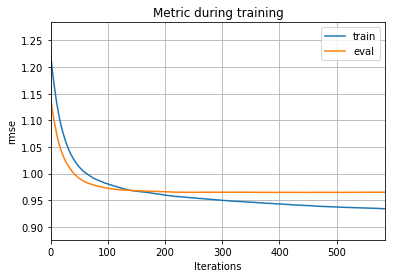

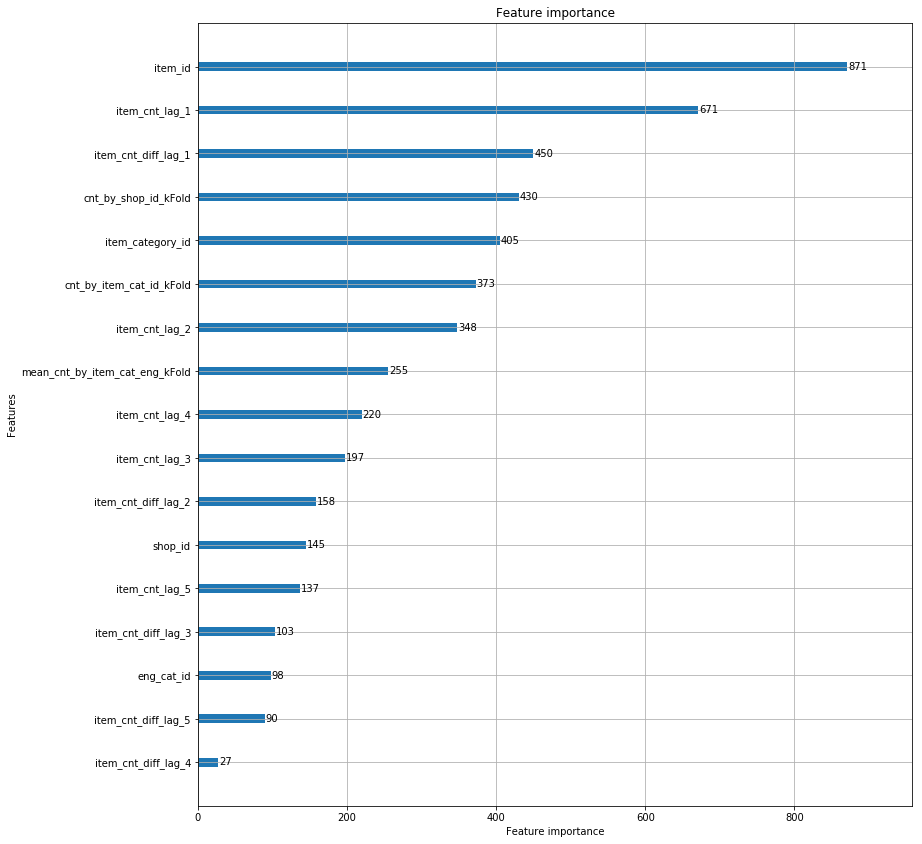

In [52]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_train.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

# Predict with test data¶

In [53]:
pred = ml.predict(model)

In [54]:
# Clip prediction to [0-20]
preds = np.clip(pred,0,20)

In [55]:
data['test'].shape

(214200, 3)

In [56]:
preds.shape

(214200,)

In [57]:
submit = pd.DataFrame({'ID':data['test'].ID,'item_cnt_month': preds })
submit.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.199563
std,61834.358168,0.683429
min,0.000000,0.000000
25%,53549.750000,0.000000
50%,107099.500000,0.039398
75%,160649.250000,0.155813
max,214199.000000,20.000000


In [58]:
pred_submit = pred

In [59]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
# pred_submit = pred

# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

214200
[ 0.30833266 -0.0147655   0.852949   ...  0.07833201 -0.04407309
  0.08423354]
Sum pred: 38828.416688146965
[0.30833266 0.         0.852949   ... 0.07833201 0.         0.08423354]


total sales pred: 42746.440661318135 , mean: 0.1995632150388335


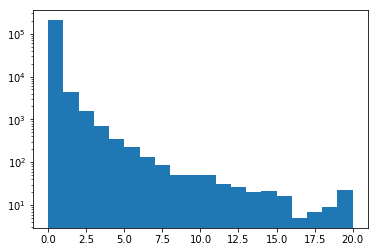

In [60]:
print 'total sales pred:',np.sum(pred_submit), ', mean:',np.mean(pred_submit)
hist_pred = plt.hist(pred_submit,bins=20,log=True)

# Validation with yearly trend

total sales count from Oct21-2018_2 prediction: 42746.440661318135
total sales count from contant 0.5 prediction: 107100.0


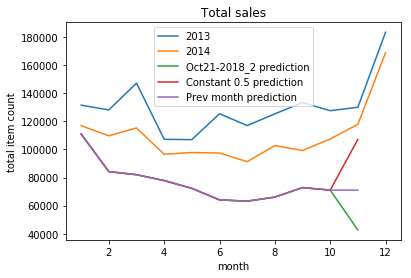

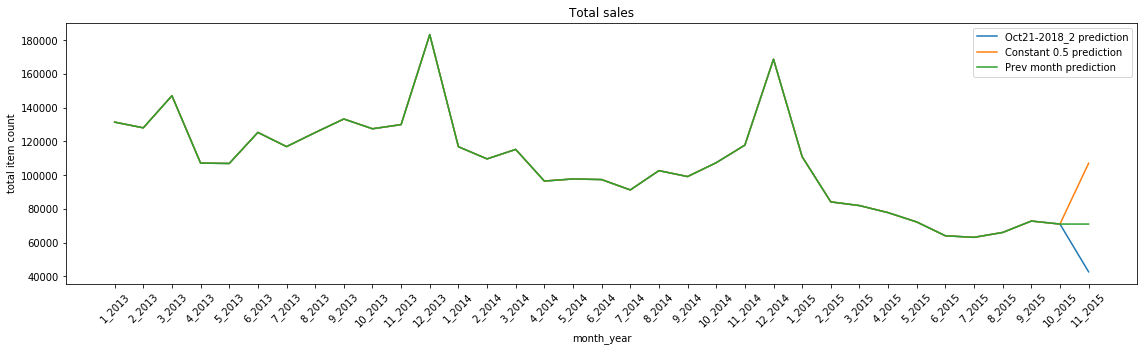

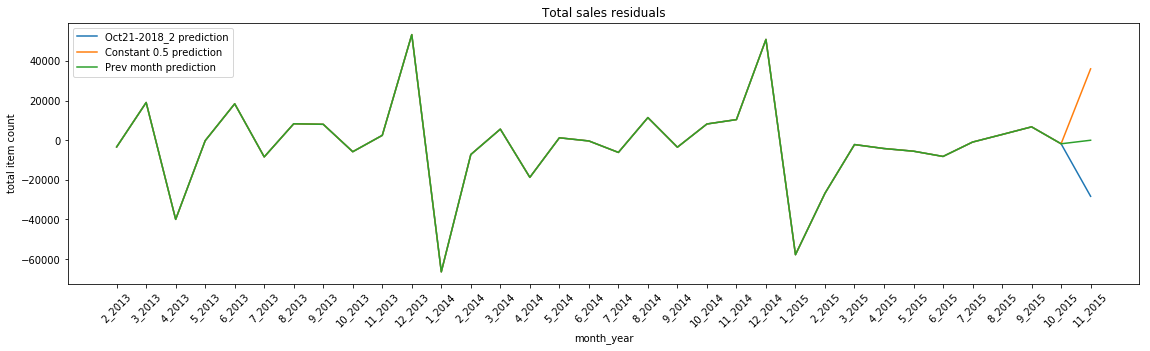

In [61]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Analyse misprediction in validation

In [62]:
#To do

# Prepare submission file

In [64]:
submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):
    submit.to_csv(saveFolder+'/'+'submit_'+submitName+'.csv',index=False)